In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# 1D Poisson Equation

Source: - Lu, L., Pestourie, R., Johnson, S. G. & Romano, G. Multifidelity deep neural operators for efficient learning of partial differential equations with application to fast inverse design of nanoscale heat transport. Phys. Rev. Research 4, 023210 (2022).

$$
\frac{d^{2}u}{dx^{2}} = 20 f(x),   x \in [0,1],\\
$$
* with the Dirichlet boundary condition $u(0) = u(1) = 0$.
* The solution operator is given by:
$$
\mathcal{G} : f \mapsto u.\\
$$
* We sample $f$ from a Gaussian random field (GRF) with mean zero:
$$
f \sim \mathcal{GP}(0,k_{l}(x_1,x_2)),\\
k_{l}(x_1,x_2) = \exp \Big[-\frac{|x_1 - x_2|^2}{2l^2} \Big], l=0.05.\\
$$
* We generate the high-fidelity and low-fidelity data sets by solving the Poisson equation via the finite difference method with different mesh size $\Delta x$.
* For the high-fidelity solutions, we use $\Delta x = 1/99$, and for the low-fidelity solutions, $\Delta x = 1/9$.
* In the high-fidelity data set we have $500$ different samples of $f$ , but for each $f$ we do not have the full field observation of the corresponding solution $u$, and instead, we only know the value of $u(x)$ at one location $x$ randomly sampled in $[0, 1]$.
* All DeepONets are trained with an Adam optimizer, SELU activation function, with a learning rate $10^{−4}$ for $50000$ epochs. 
* We test DeepONets with different width, and the DeepONet with the width 5 has the smallest test mse.
* The mean and standard deviation of the error are obtained by ten runs with a randomly generated data set and random network initialization.

In [ ]:
# Imports
from data.spaces import GRF, space_samples

# space = GRF(1, length_scale=0.2, N=1000, interp="cubic")
# space_samples(space, 1)

In [ ]:
# Example of Low & High Fidelity Data
from data.poisson import example
example()

In [ ]:
# Generate Data
from data.poisson import gen_data

gen_data(fname="train", plot_figures=True)

In [ ]:
gen_data(fname="test", plot_figures=False)

In [1]:
from data.data_utils import get_data

fname_train = "./data/train.npz"
fname_test = "./data/test.npz"

# Residual is False
X_train, y_train, X_test, y_test = get_data(
    fname_train, fname_test, residual=False, stackbranch=False, stacktrunk=False
)

# DeepONet Training using DeepXDE

## Low Fidelity Solver

In [2]:
import deepxde as dde

data = dde.data.Triple(
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
    )

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
m = 100
dim_x = 1
width = 5
net = dde.nn.DeepONet(
    [m, width, width],
    [dim_x, width],
    "selu",
    "Glorot normal",
)
print(net)

DeepONet(
  (branch): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=100, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=5, bias=True)
    )
  )
  (trunk): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=5, bias=True)
    )
  )
  (b): ParameterList(  (0): Parameter containing: [torch.float32 of size ])
)


Compiling model...
'compile' took 0.002125 s



Training model...

Step      Train loss    Test loss     Test metric
0         [1.95e-01]    [2.33e-01]    []  
1000      [8.09e-02]    [1.37e-01]    []  
2000      [7.09e-02]    [1.38e-01]    []  
3000      [5.95e-02]    [1.24e-01]    []  
4000      [3.56e-02]    [7.28e-02]    []  
5000      [2.58e-02]    [5.68e-02]    []  
6000      [2.10e-02]    [4.84e-02]    []  
7000      [1.72e-02]    [4.55e-02]    []  
8000      [1.42e-02]    [4.56e-02]    []  
9000      [1.18e-02]    [4.42e-02]    []  
10000     [9.83e-03]    [4.18e-02]    []  
11000     [8.23e-03]    [4.11e-02]    []  
12000     [7.36e-03]    [3.86e-02]    []  
13000     [6.36e-03]    [3.62e-02]    []  
14000     [5.84e-03]    [3.31e-02]    []  
15000     [5.43e-03]    [3.04e-02]    []  
16000     [5.15e-03]    [2.86e-02]    []  
17000     [4.93e-03]    [2.76e-02]    []  
18000     [4.77e-03]    [2.68e-02]    []  
19000     [4.64e-03]    [2.62e-02]    []  
20000     [4.51e-03]    [2.55e-02]    []  
21000     [4.40e-03]    [2.5

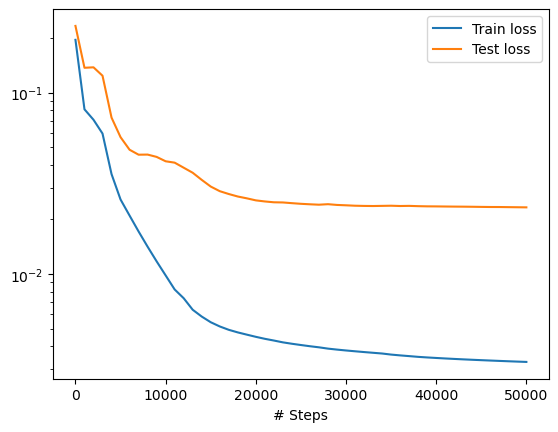

In [5]:
lr = 0.0001
epochs = 50000

def run(data, net, lr, epochs):
    model = dde.Model(data, net)
    model.compile("adam", lr=lr)
    losshistory, train_state = model.train(epochs=epochs)
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)


run(data, net, lr, epochs)

## High Fidelity Solver

In [6]:
X_train, y_train, X_test, y_test = get_data(
    fname_train, fname_test, residual=True, stackbranch=False, stacktrunk=False
)

In [7]:
data = dde.data.Triple(
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
    )

Compiling model...
'compile' took 0.006249 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.60e+00]    [1.78e+00]    []  
1000      [4.07e-02]    [4.78e-02]    []  
2000      [1.89e-02]    [2.48e-02]    []  
3000      [1.24e-02]    [1.79e-02]    []  
4000      [1.01e-02]    [1.53e-02]    []  
5000      [8.67e-03]    [1.44e-02]    []  
6000      [7.69e-03]    [1.38e-02]    []  
7000      [6.81e-03]    [1.30e-02]    []  
8000      [6.07e-03]    [1.26e-02]    []  
9000      [5.57e-03]    [1.22e-02]    []  
10000     [4.95e-03]    [1.14e-02]    []  
11000     [4.20e-03]    [1.02e-02]    []  
12000     [3.45e-03]    [8.86e-03]    []  
13000     [3.05e-03]    [8.57e-03]    []  
14000     [2.51e-03]    [7.16e-03]    []  
15000     [1.92e-03]    [5.19e-03]    []  
16000     [1.39e-03]    [3.50e-03]    []  
17000     [1.20e-03]    [2.88e-03]    []  
18000     [1.07e-03]    [2.64e-03]    []  
19000     [9.29e-04]    [2.41e-03]    []  
20000     [7.17e-04]    [

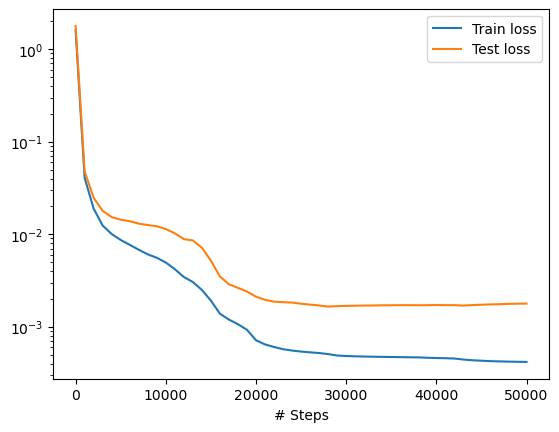

In [9]:
run(data, net, lr, epochs)

In [ ]:
# (u_train, y_train), G_train, (u_test, y_test), G_test = X_train, y_train, X_test, y_test

# print(f"Shape of u_train: {u_train.shape}")
# print(f"Shape of y_train: {y_train.shape}")
# print(f"Shape of G_train: {G_train.shape}")
# print(f"Shape of u_test: {u_test.shape}")
# print(f"Shape of y_test: {y_test.shape}")
# print(f"Shape of G_test: {G_test.shape}")

In [ ]:
# # Residual is True
# """
# 1.) residual=True: Removes LF data points from HF data G_train/y_train.
# 2.) stackbranch=True: Horizontally Stacks Low Fidelity Data with f
# 3.) stacktrunk=True: Horizontaly Stacks the Low Fidelity y_train/x points with High Fidelity y_train/x_points
# """
# X_train, y_train, X_test, y_test = get_data(
#     fname_train, fname_test, residual=True, stackbranch=False, stacktrunk=False
# )